In [1]:
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
import gsw
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter as gf
import numpy as np

Data is from feb 1 to 5

In [2]:
ds_day1 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120201.nc')
ds_day2 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120202.nc')
ds_day3 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120203.nc')
#ds_day4 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120204.nc')
#ds_day5 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120205.nc')

Combine them together

In [3]:
ds_concat = xr.concat([ds_day1, ds_day2, ds_day3], dim='time')

In [4]:
time_window = 24 # in hours
time_selected = 25
lat_selected = 100
ds_avg = ds_concat.rolling(time=time_window).mean() # running mean
#ds = ds.isel(time=time_selected)

In [5]:
ds = ds_avg.isel(time = time_selected)

In [6]:
ds = ds.assign_coords(Z=('k',ds.Z))
ds = ds.assign_coords(X=(('j_g','i_g'), ds.XG))
ds = ds.assign_coords(XC=(('j','i'), ds.XC))
ds = ds.assign_coords(YC=(('j','i'), ds.YC))

In [7]:
ds['p'] = ('k', gsw.p_from_z(ds.Z,ds.YC.mean()))
p,XC,YC = xr.broadcast(ds.p,ds.XC,ds.YC)
ds['SA'] = (('k','j','i'), gsw.SA_from_SP(ds.Salt,p,XC,YC))
ds['CT'] = (('k','j','i'), gsw.CT_from_t(ds.SA,ds.Theta,p))
#dss['geo_strf_height'] = (('k','j','i'), gsw.geo_strf_dyn_height(dss.Salt, dss.Theta, -dss.Z))
p_ref = 500
ds['geo_height'] = (('k','j','i'),gsw.geo_strf_dyn_height(ds.SA,ds.CT,-ds.Z,p_ref))

In [8]:
[geostrophic_velocity, mid_lat, mid_long] = gsw.geostrophic_velocity(ds.geo_height.isel(j = 100),
                                                                     ds.XC.isel(j = 100),ds.YC.isel(j = 100))

In [9]:
geo_U, midlon1, midlat1 = gsw.geostrophic_velocity(
    ds.geo_height.isel(i = 100),
    ds.XC.isel(i = 100),
    ds.YC.isel(i= 100))

In [10]:
zero = np.zeros(89)
hzero = zero.reshape(89,1)
geo_v_whole = np.append(geostrophic_velocity,hzero,axis = 1)

In [11]:
ds['geo_V'] = (('k','i'),geo_v_whole)

In [12]:
geo_u_whole = np.append(geo_U,hzero,axis = 1)
ds['geo_U'] = (('k','j'),geo_u_whole)

Text(0.5, 1.0, 'Geostrophic_U')

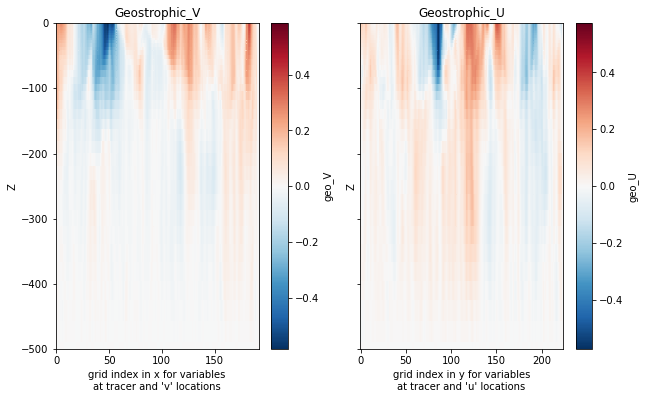

In [13]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
ds.geo_V.plot(y = 'Z',ax = ax[0])
ds.geo_U.plot(y = 'Z',ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic_V')
ax[1].set_title('Geostrophic_U')

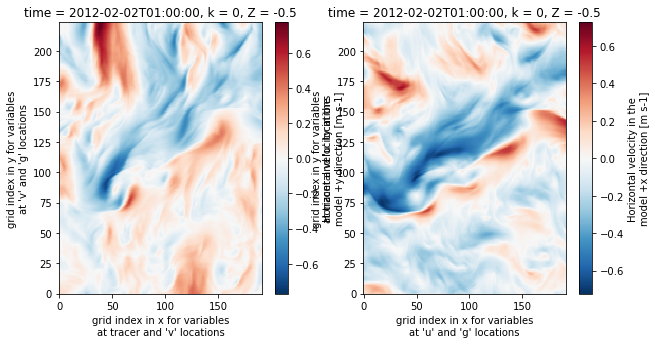

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ds.isel(k = 0).V.plot(ax = ax[0])
ds.isel(k = 0).U.plot(ax = ax[1])

In [13]:
grid = xgcm.Grid(ds, coords={"X": {"center": "i", "left": "i_g"}, 
 "Y": {"center": "j", "left": "j_g"},
 "Z": {"center": "k"},
 "T": {"center": "time"},}, metrics = {('X',):['DXC', 'DXG'],
                                       ('Y',):['DYC', 'DYG'],
                                       ('X','Y'): ['RAZ']})

grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
Z Axis (periodic, boundary=None):
  * center   k
T Axis (periodic, boundary=None):
  * center   time

In [14]:
ds['zeta'] = (-grid.diff(ds.U * ds.DXC, 'Y', boundary='extend') +
                    grid.diff(ds.V * ds.DYC, 'X', boundary='extend'))/ds.RAZ

In [15]:
ds['gf_Geo_V'] = (('k', 'i'), gf(ds.geo_V, sigma = 10, mode='nearest',cval=0)) 
ds['gf_Geo_U'] = (('k', 'j'), gf(ds.geo_U, sigma = 10, mode='nearest',cval=0))

In [18]:
gap = midlat1[1]-midlat1[0]
gap1 = mid_lat[1] - mid_lat[0]
add = midlat1[222] + gap
add1 = mid_lat[190] + gap1
midlat1 = np.append(midlat1,add)
mid_lat = np.append(mid_lat,add1)

Text(0.5, 1.0, 'Geostrophic_U')

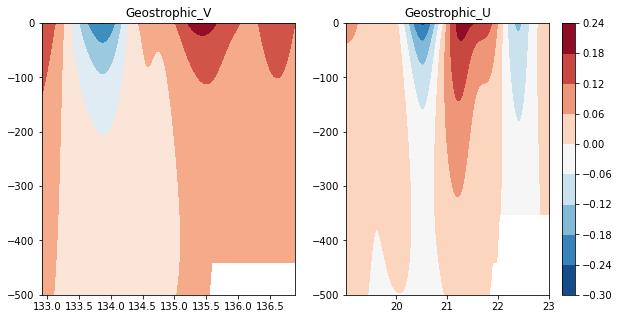

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(mid_lat,ds.Z,ds.gf_Geo_V, cmap='RdBu_r')
h = ax[1].contourf(midlat1,ds.Z,ds.gf_Geo_U, cmap='RdBu_r')
plt.colorbar(h)
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic_V')
ax[1].set_title('Geostrophic_U')

Text(0.5, 1.0, 'Geostrophic_U')

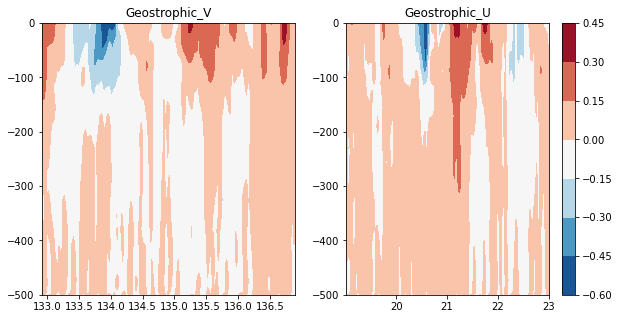

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(mid_lat,ds.Z,ds.geo_V, cmap='RdBu_r')
h = ax[1].contourf(midlat1,ds.Z,ds.geo_U, cmap='RdBu_r')
plt.colorbar(h)
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic_V')
ax[1].set_title('Geostrophic_U')

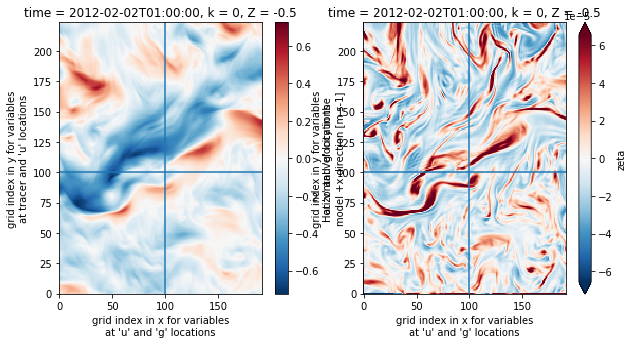

In [24]:
fig, ax = plt.subplots(1,2, figsize= (10,5))
ds.zeta.isel(k=0).plot(robust = True,ax = ax[1])
ds.U.isel(k=0).plot(ax = ax[0])
ax[0].axhline(100)
ax[0].axvline(100)
ax[1].axhline(100)
ax[1].axvline(100)

Text(0.5, 1.0, 'vorticity constant i')

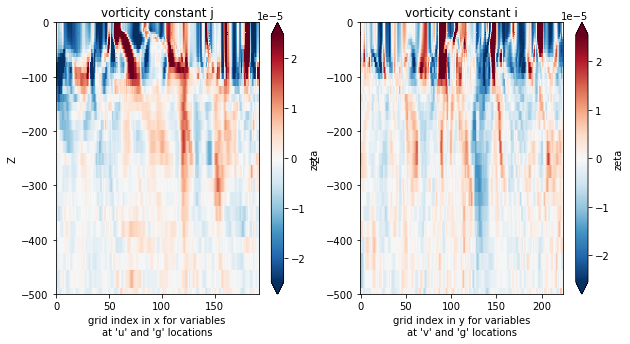

In [25]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.zeta.isel(j_g = 100).plot(robust = True,y  = 'Z', ax = ax[0])
ds.zeta.isel(i_g = 100).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('vorticity constant j')
ax[1].set_title('vorticity constant i')

In [16]:
ds['K_energy'] = grid.interp(ds.U**2, ['X','Y'], boundary = 'extend') + (ds.V)**2

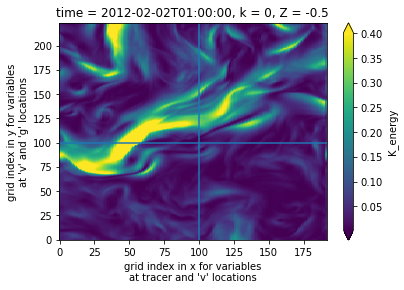

In [27]:
ds.K_energy.isel(k=0).plot(robust = True)
plt.axhline(100)
plt.axvline(100)

Text(0.5, 1.0, 'constant i')

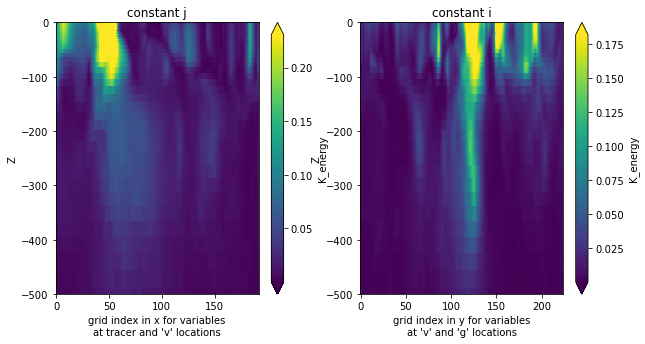

In [28]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.K_energy.isel(j_g = 100).plot(robust = True,y  = 'Z', ax = ax[0])
ds.K_energy.isel(i = 100).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('constant j')
ax[1].set_title('constant i')

In [17]:
ds['density'] = (('k','j','i'),gsw.rho(ds.SA, ds.CT, p)-1000)

In [18]:
ds['f'] = (('j'),gsw.f(ds.YC.mean(dim = 'i'))) #Coriolis force

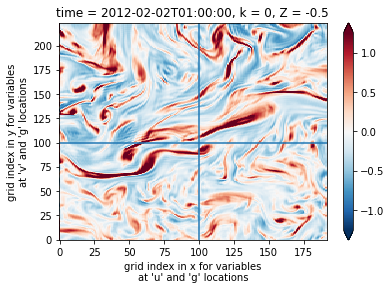

In [31]:
(ds.zeta.isel(k=0)/ds.f.mean()).plot(robust = True)
plt.axhline(100)
plt.axvline(100)
plt.savefig('zeta over f.png')

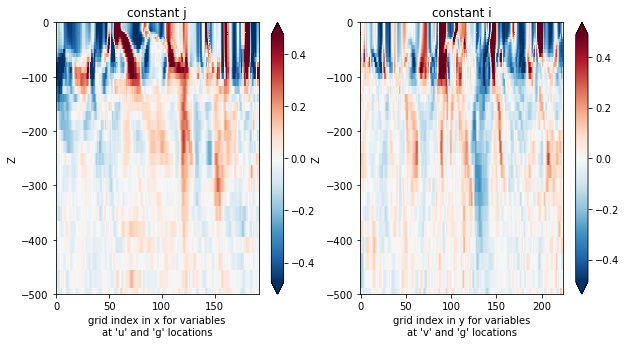

In [57]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

(ds.zeta.isel(j_g = 100)/ds.f.mean()).plot(robust = True,y  = 'Z', ax = ax[0])
(ds.zeta.isel(i_g = 100)/ds.f.mean()).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('constant j')
ax[1].set_title('constant i')
plt.savefig('zeta over f with constant i and j')

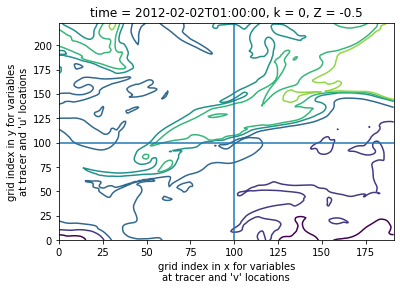

In [56]:
ds.density.isel(k=0).plot.contour(robust = True) 
plt.axhline(100)
plt.axvline(100)


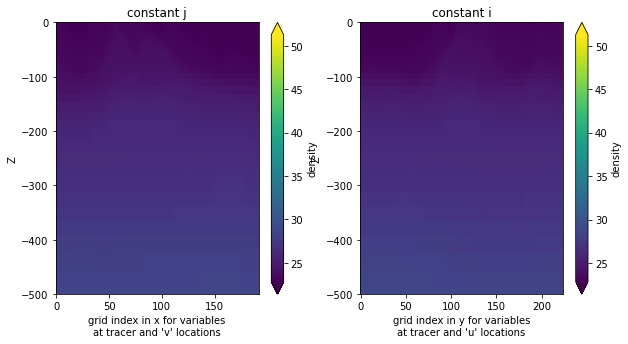

In [58]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.density.isel(j =100).plot(robust = True,y  = 'Z', ax = ax[0])
ds.density.isel(i =100).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('constant j')
ax[1].set_title('constant i')
plt.savefig('density i and j')

(-500.0, 0.0)

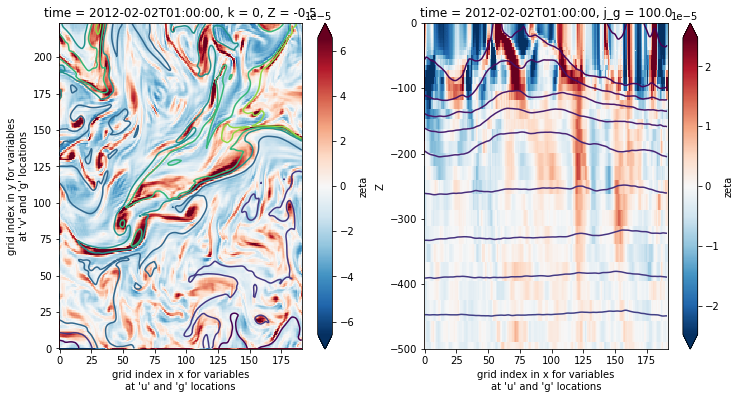

In [79]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.zeta.isel(k=0).plot(robust = True, ax = ax[0])
ds.density.isel(j=100).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.zeta.isel(j_g=100).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)

In [9]:
ds

<xarray.Dataset>
Dimensions:         (i: 192, i_g: 192, j: 224, j_g: 224, k: 89, k_l: 89, k_p1: 90, k_u: 89, log_shear_i: 19936, nb: 2)
Coordinates: (12/15)
  * i               (i) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j               (j) float32 0.0 1.0 2.0 3.0 4.0 ... 220.0 221.0 222.0 223.0
    time            datetime64[ns] 2012-02-02T01:00:00
    XC              (j, i) float32 ...
    YC              (j, i) float32 ...
  * i_g             (i_g) float32 0.0 1.0 2.0 3.0 ... 188.0 189.0 190.0 191.0
    ...              ...
    Z               (k) float32 ...
  * k_p1            (k_p1) int32 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
  * k_u             (k_u) int32 0 1 2 3 4 5 6 7 8 ... 80 81 82 83 84 85 86 87 88
  * k_l             (k_l) int32 0 1 2 3 4 5 6 7 8 ... 80 81 82 83 84 85 86 87 88
    X               (j_g, i_g) float32 ...
  * log_shear_i     (log_shear_i) float64 -3.284 -3.202 -3.205 ... nan nan nan
Data variables: (12/56)
    DXV             (j, i) float32 ...
    DYU             (j, i) float32 ...
    Depth           (j, i) float32 ...
    DXC             (j, i_g) float32 ...
    DYG             (j, i_g) float32 ...
    DYC             (j_g, i) float32 ...
    ...              ...
    Q_1             (k, j, i) float64 ...
    turbulence      (k, j, i) float64 ...
    log_PV          (k, j, i) float64 ...
    log_tur         (k, j, i) float64 ...
    log_shear       (k, j_g, i) float64 ...
    log_stra        (k, j, i) float64 ...
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-02-01 23:00:00
    time_coverage_start:             2012-02-01 00:00:00
    title:                           LLC4320 regional Northwest Pacific
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

In [19]:
ds['shear_sq'] = grid.interp(ds.U.differentiate('Z')**2, ['X','Y'], boundary = 'extend') + ds.V.differentiate('Z')**2

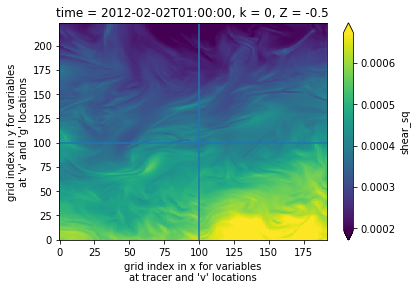

In [38]:
ds.shear_sq.isel(k=0).plot(robust = True)
plt.axhline(100)
plt.axvline(100)

Text(0.5, 1.0, 'constant i for Shear Square')

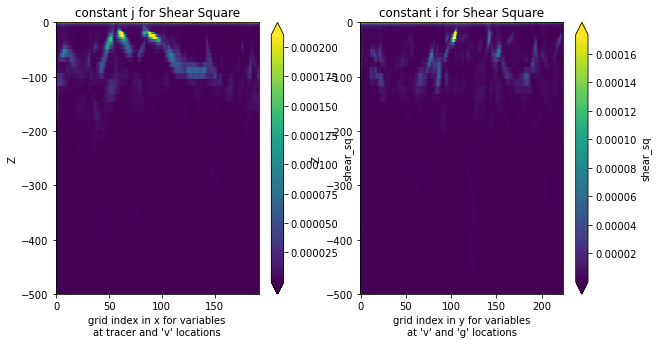

In [39]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.shear_sq.isel(j_g = 100).plot(robust = True,y  = 'Z', ax = ax[0])
ds.shear_sq.isel(i = 100).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('constant j for Shear Square')
ax[1].set_title('constant i for Shear Square')

(-500.0, 0.0)

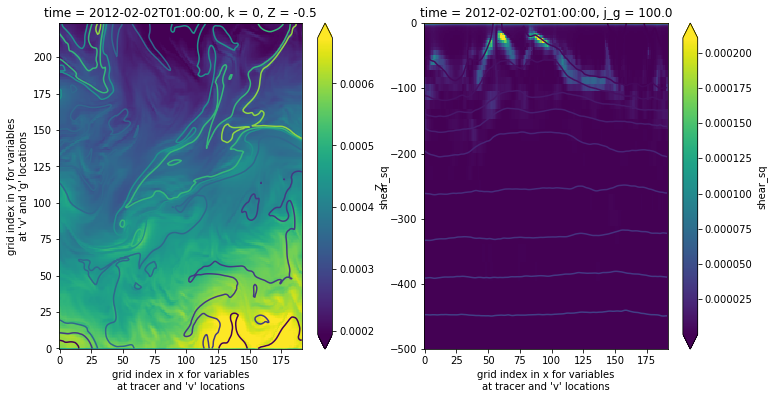

In [40]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.shear_sq.isel(k=0).plot(robust = True, ax = ax[0])
ds.density.isel(j=100).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.shear_sq.isel(j_g=100).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)

stratification. You can compute stratification with gsw.Nsquared(SA,CT,p).

In [20]:
N2, kmid = gsw.Nsquared(ds.SA,ds.CT, p)

In [21]:
ad = N2[87] - N2[86] + N2[87]
ad.shape

(224, 192)

In [22]:
N2.shape

(88, 224, 192)

In [23]:
new  = np.append(N2, np.atleast_3d(ad)).reshape(89,224,192)

In [24]:
new.shape

(89, 224, 192)

In [25]:
ds['stratification'] = (('k','j','i'),new) 

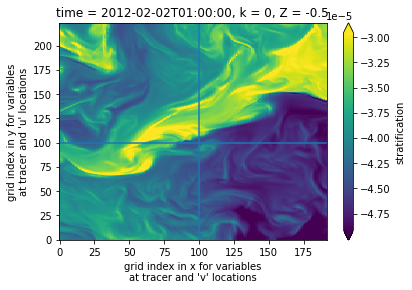

In [26]:
ds.stratification.isel(k=0).plot(robust = True)
plt.axhline(100)
plt.axvline(100)

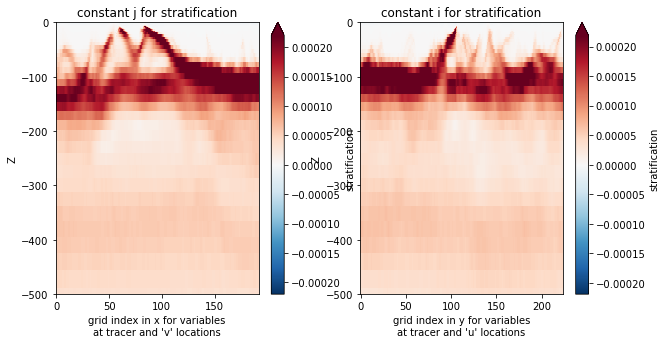

In [86]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.stratification.isel(j = 100).plot(robust = True,y  = 'Z', ax = ax[0])
ds.stratification.isel(i = 100).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('constant j for stratification')
ax[1].set_title('constant i for stratification')
plt.savefig('stratification')

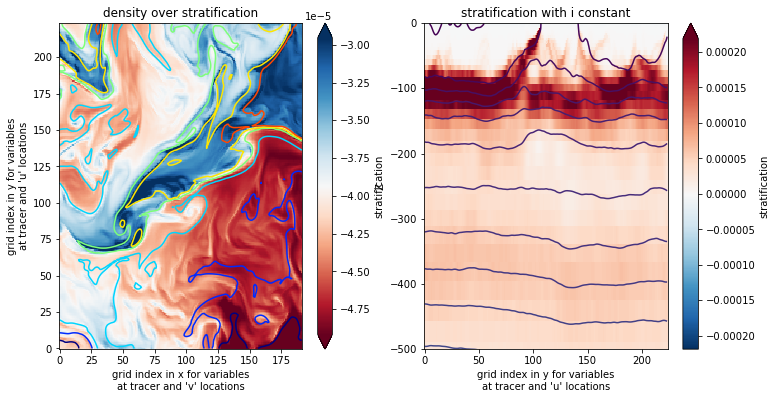

In [93]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0], cmap = 'jet')
ds.stratification.isel(k=0).plot(robust = True, ax = ax[0], cmap = 'RdBu')
ds.density.isel(i=100).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.stratification.isel(i=100).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)
ax[0].set_title('density over stratification')
ax[1].set_title('stratification with i constant') 

/Users/Daniel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


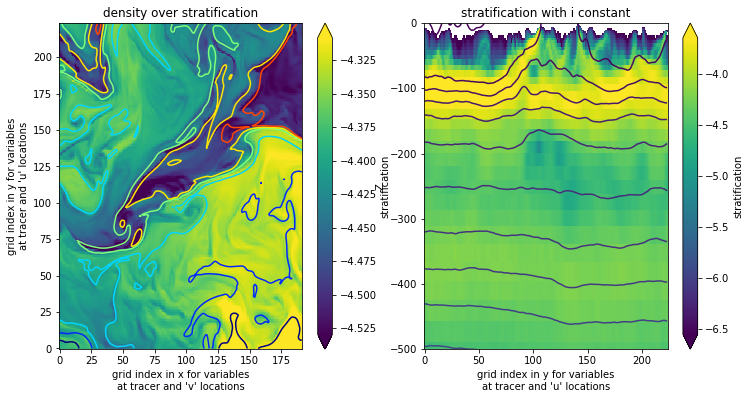

In [101]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0], cmap = 'jet')
(-ds.stratification.isel(k=0)).pipe(np.log10).plot(robust = True, ax = ax[0], cmap = 'viridis')
ds.density.isel(i=100).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.stratification.isel(i=100).pipe(np.log10).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)
ax[0].set_title('density over stratification')
ax[1].set_title('stratification with i constant') 

### Potential Vorticity

This is the nabla x U (you can try to write out the cross product):

Wx = -dv/dz

Wy = -du/dz

Wz = dv/dx - du/dy (this is =zeta the vorticity).

And then the three components of the density (rho) gradients:

dRho/dx

dRho/dy

dRho/dz 

By the way, the stratification N2 = -(1/Rho)*dRho/dz! 

And then the potential vorticity is:

Q = -(Wx*dRho/dx + Wy*dRho/dy + (f+Wz)*dRho/dz )/Rho

In [27]:
ds['Wx'] = -ds.V.differentiate('Z')

In [28]:
ds['Wy'] = -ds.U.differentiate('Z')

In [29]:
ds['grad_rho_x'] = grid.derivative(ds.density, 'X', boundary='extend')

In [30]:
ds['grad_rho_y'] = grid.derivative(ds.density, 'Y', boundary='extend')

In [31]:
ds['grad_rho_z'] = ds.density.differentiate('Z')

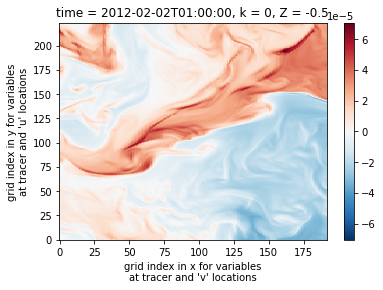

In [73]:
(-ds.grad_rho_z.isel(k=0) * (1/ds.density.mean())).plot()

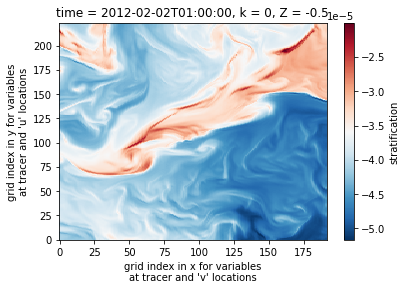

In [31]:
ds.stratification.isel(k=0).plot(cmap = 'RdBu_r')

Wx: k, j_g, i

Wy: k, j, i_g

Wz(zeta):k, j_g, i_g

rho_x: k, j, i_g

rho_y: k, j_g, i 

rho_z:k, j, i

rho: k, j, i

In [32]:
ds['Q'] = -(grid.interp(ds.Wx, ['Y'], boundary = 'extend') * grid.interp(ds.grad_rho_x, ['X'], boundary = 'extend')  #j, i
      + grid.interp(ds.Wy,['X'], boundary = 'extend') * grid.interp(ds.grad_rho_y, ['Y'], boundary = 'extend')   #j ,i
      + (grid.interp(ds.zeta, ['X','Y'], boundary = 'extend') + ds.f)*ds.grad_rho_z # j, i 
     )/ds.density # j, i

In [33]:
ds['Q_1'] = -(grid.interp(ds.Wx, ['Y'], boundary = 'extend') * grid.interp(ds.grad_rho_x, ['X'], boundary = 'extend')  #j, i
      + grid.interp(ds.Wy,['X'], boundary = 'extend') * grid.interp(ds.grad_rho_y, ['Y'], boundary = 'extend')   #j ,i
      + (grid.interp(ds.zeta, ['X','Y'], boundary = 'extend') + ds.f)*ds.grad_rho_z # j, i 
     )/ds.density.mean() # j, i

Text(0.5, 1.0, 'Q')

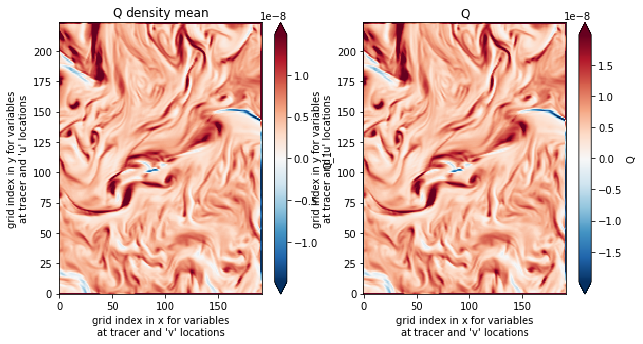

In [99]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.Q_1.isel(k=2).plot(robust = True, ax = ax[0])
ds.Q.isel(k=2).plot(robust=True, ax=ax[1])
ax[0].set_title('Q density mean')
ax[1].set_title('Q')

Text(0.5, 1.0, 'surface')

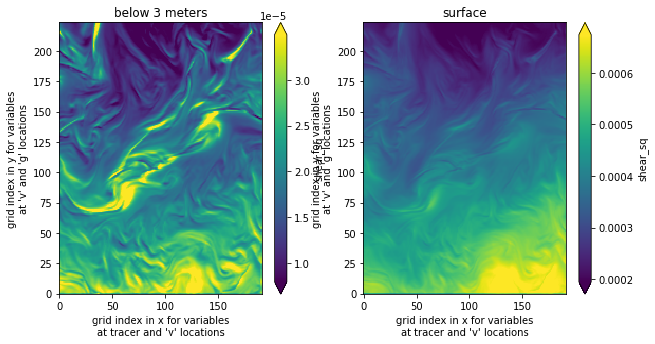

In [112]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ds.shear_sq.isel(k=3).plot(robust = True, ax = ax[0])
ds.shear_sq.isel(k=0).plot(robust = True, ax = ax[1])

ax[0].set_title('below 3 meters')
ax[1].set_title('surface')

(-100.0, 0.034999966621398926)

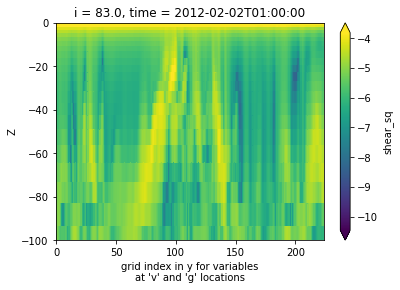

In [43]:
ds.shear_sq.isel(i = 83).pipe(np.log10).plot(y = 'Z', robust = True)
plt.ylim(-100)

Text(0.5, 1.0, 'TAUY')

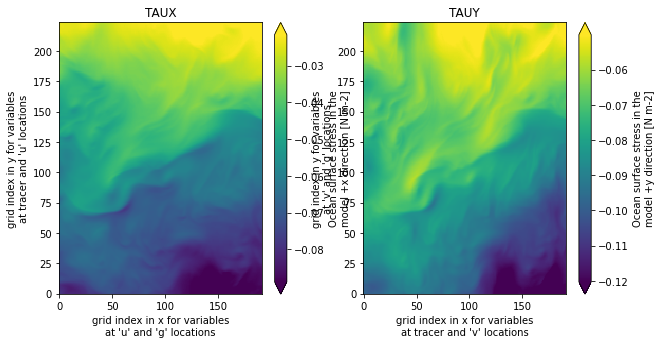

In [117]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ds.oceTAUX.plot(robust = True, ax = ax[0])
ds.oceTAUY.plot(robust = True, ax = ax[1])

ax[0].set_title('TAUX')
ax[1].set_title('TAUY')

(-20.0, 0.034999966621398926)

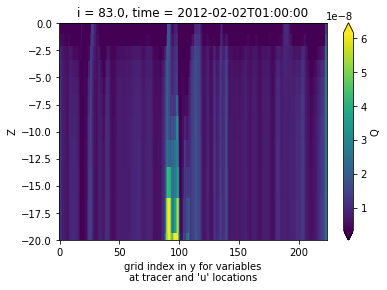

In [93]:
ds.Q.isel(i = 83).plot(y = 'Z', robust = True)
plt.ylim(-20)

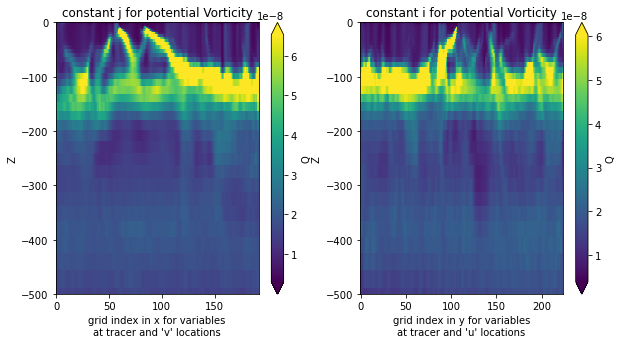

In [61]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.Q.isel(j = 100).plot(robust = True,y  = 'Z', ax = ax[0])
ds.Q.isel(i = 100).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('constant j for potential Vorticity')
ax[1].set_title('constant i for potential Vorticity')

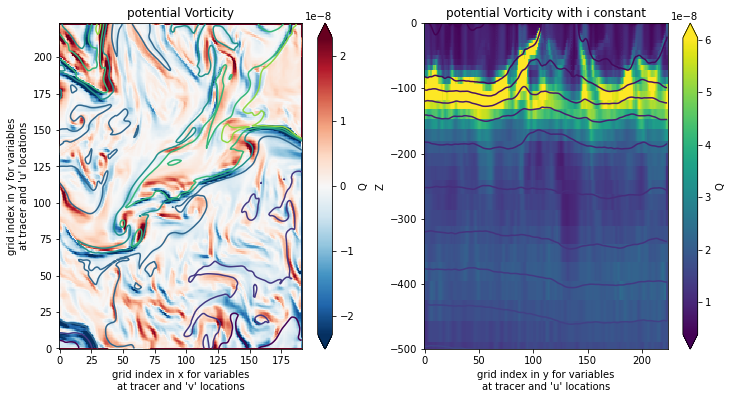

In [60]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.Q.isel(k=0).plot(robust = True, ax = ax[0])
ds.density.isel(i=100).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.Q.isel(i=100).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)
ax[0].set_title('potential Vorticity')
ax[1].set_title('potential Vorticity with i constant')

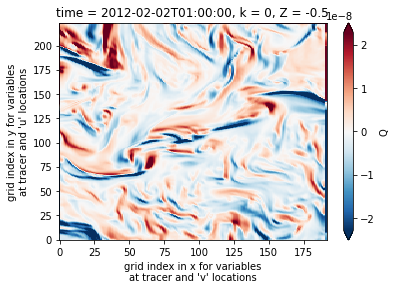

In [65]:
ds.Q.isel(k=0).plot(robust = True)

In [34]:
ds['turbulence'] = ds.stratification/ grid.interp(ds.shear_sq, ['Y'], boundary = 'extend')

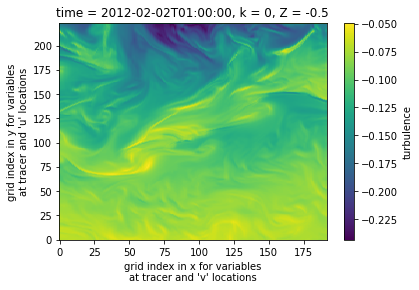

In [53]:
ds.turbulence.isel(k=0).plot()
plt.savefig('turbulence')

/Users/Daniel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


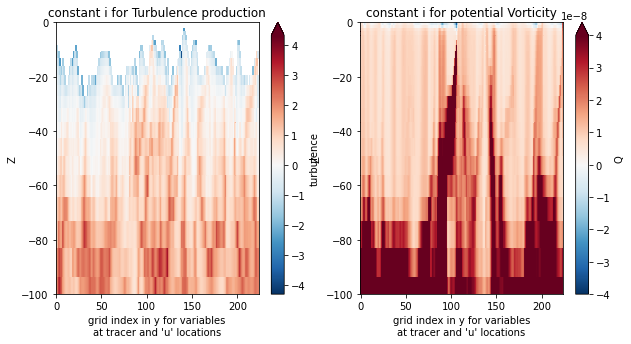

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.turbulence.isel(i = 100).pipe(np.log10).plot(robust = True,y  = 'Z',ax = ax[0])
ds.Q.isel(i = 100).plot(robust=True, y = 'Z',cmap = 'RdBu_r',vmin=-4e-8, vmax=4e-8,ax = ax[1])
ax[0].set_ylim(-100,0)
ax[1].set_ylim(-100,0)
ax[0].set_title('constant i for Turbulence production')
ax[1].set_title('constant i for potential Vorticity')
plt.savefig('PV and Richrdson 0-100')

In [35]:
ds['log_PV'] = np.log10(-ds.Q)

/Users/Daniel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [36]:
ds['log_tur'] = np.log10(ds.turbulence)

In [37]:
ds['log_shear'] = np.log10(ds.shear_sq)

In [8]:
ds['log_shear_i'] = ds.log_shear.isel(i= 100).values.flatten()

In [38]:
ds['log_stra'] = np.log10(ds.stratification)

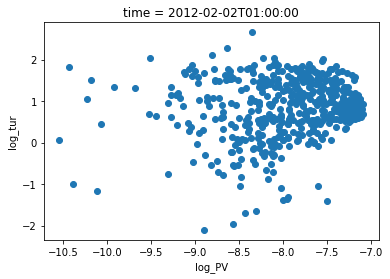

In [56]:
ds.plot.scatter(x = 'log_PV', y = 'log_tur')

In [2]:
ds = xr.open_dataset('full_variables.nc')

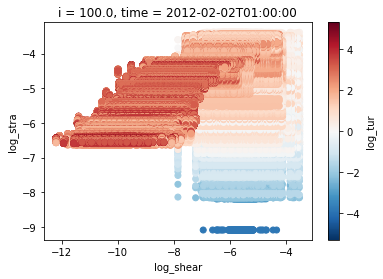

In [6]:
ds.isel(i = 100).plot.scatter(x = 'log_shear', y = 'log_stra', hue = 'log_tur')


In [38]:
ds.Q.values

array([[[ 1.36020015e-07,  1.41631099e-07,  1.39399912e-07, ...,
          2.27266780e-07,  2.30301031e-07,  2.28534919e-07],
        [-1.13486194e-08, -2.87299726e-09, -3.58145453e-09, ...,
         -2.64226914e-09, -1.83484330e-09, -1.36054886e-08],
        [-1.11515582e-08, -3.10909067e-09, -3.83645136e-09, ...,
         -1.92801051e-09, -1.02782089e-09, -1.37673899e-08],
        ...,
        [ 7.48888239e-08,  8.02345525e-09,  8.11223765e-09, ...,
          1.40882536e-09, -5.88484998e-11,  6.23207706e-08],
        [ 7.53549040e-08,  6.88859313e-09,  6.93993940e-09, ...,
          1.17317757e-09, -1.92626117e-09,  6.25470790e-08],
        [ 1.45222626e-07,  6.29703004e-08,  6.07452914e-08, ...,
          7.87014234e-08,  6.59710112e-08,  1.63119122e-07]],

       [[ 1.02346974e-07,  1.04412112e-07,  1.02729574e-07, ...,
          1.72153805e-07,  1.74657258e-07,  1.73693968e-07],
        [-4.22999594e-09,  1.51923363e-10, -1.84196653e-10, ...,
          6.92369816e-10,  1.15027017e